# LSTM

In [26]:
import pandas as pd
import numpy as np

In [27]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

Number of GPU:  1
GPU Name:  NVIDIA GeForce GTX 1650
GPU: NVIDIA GeForce GTX 1650 is available.


In [28]:
#Configure device: Set the device configuration to GPU using the torch.device class in PyTorch:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


In [29]:
bca = pd.read_csv("bca_preprocessed_half.csv", delimiter=',')
bca.head(5)

,content,score,sentiment
0,pelayanan buruk trouble tidak ada info era dig...,1,0
1,kenapa sih ini verif aplikasinya susah banget ...,1,0
2,notifikasi transaksi tidak bisa di edit hapus ...,1,0
3,tidak bisa dibuka selalu force close talkback ...,1,0
4,ok bagus dan membantun,5,2


In [30]:
bca.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [31]:
bca = bca.dropna()

In [32]:
bca.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [33]:
#Split features (content) and labels (sentiment)

X = bca['content']
y = bca['sentiment']

In [34]:
# Check dataset balance and apply oversampling for "Neutral" class if needed
print("Before balancing:")
print(y.value_counts())

Before balancing:
sentiment
0    4181
2    2188
1     631
Name: count, dtype: int64


In [35]:
# Oversampling technique
from sklearn.utils import resample

bca_clean_again = pd.concat([X, y], axis=1)

#separating each class

class_0 = bca_clean_again[bca_clean_again['sentiment'] == 0]
class_1 = bca_clean_again[bca_clean_again['sentiment'] == 1]
class_2 = bca_clean_again[bca_clean_again['sentiment'] == 2]

#oversampling neutral class 1 with majority class 2

class_1_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=len(class_0), random_state=42)


#combine all class
bca_clean_again = pd.concat([class_0, class_1_oversampled, class_2_oversampled])

#shuffling the data
bca_clean_again = bca_clean_again.sample(frac=1, random_state=42)

X = bca_clean_again['content']
y = bca_clean_again['sentiment']

In [36]:
# Check dataset balance and apply oversampling for "Neutral" class if needed
print("After balancing:")
print(y.value_counts())

After balancing:
sentiment
0    4181
2    4181
1    4181
Name: count, dtype: int64


In [37]:
#Tokenization
from nltk.tokenize import word_tokenize
from collections import Counter

X = [word_tokenize(text.lower()) for text in X]

Max length: 103
Mean length: 19.14
95th percentile: 52.0
90th percentile: 40.0
80th percentile: 30.0


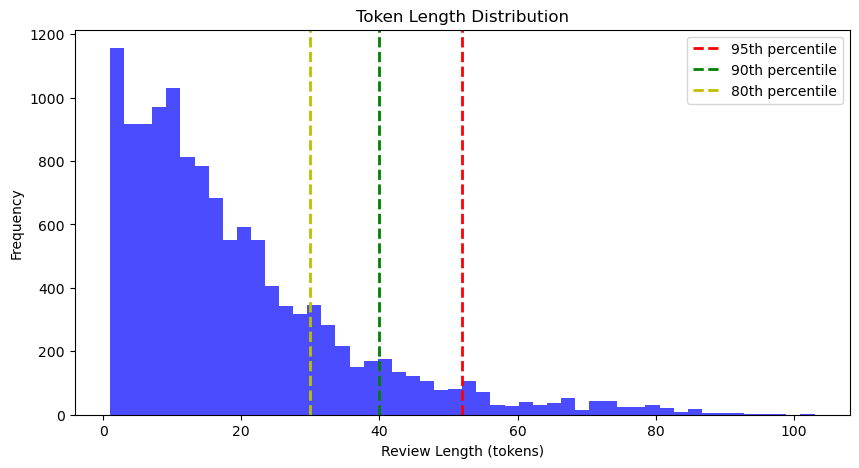

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Get tokenized lengths
token_lengths = [len(sentence) for sentence in X]

# Print statistics
print(f"Max length: {max(token_lengths)}")
print(f"Mean length: {np.mean(token_lengths):.2f}")
print(f"95th percentile: {np.percentile(token_lengths, 95)}")
print(f"90th percentile: {np.percentile(token_lengths, 90)}")
print(f"80th percentile: {np.percentile(token_lengths, 80)}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(token_lengths, bins=50, alpha=0.7, color='b')
plt.axvline(np.percentile(token_lengths, 95), color='r', linestyle='dashed', linewidth=2, label="95th percentile")
plt.axvline(np.percentile(token_lengths, 90), color='g', linestyle='dashed', linewidth=2, label="90th percentile")
plt.axvline(np.percentile(token_lengths, 80), color='y', linestyle='dashed', linewidth=2, label="80th percentile")
plt.xlabel("Review Length (tokens)")
plt.ylabel("Frequency")
plt.title("Token Length Distribution")
plt.legend()
plt.show()

In [39]:
#build vocabulary

word_counts = Counter(word for sentence in X for word in sentence)
vocab = {word: i+1 for i, (word, _)in enumerate(word_counts.most_common())}
vocab["PAD"] = 0

#Convert text to sequences
X = [[vocab[word]for word in sentence]for sentence in X]

# Padding
def pad_sequence(sequences, maxlen):
    return [seq[:maxlen] + [0] * (maxlen - len(seq)) if len(seq) < maxlen else seq[:maxlen] for seq in sequences]

maxlen = 103
X = pad_sequence(X, maxlen)

In [40]:
#Split dataset
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [41]:
#convert to tensors

X_train, y_train = torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train.values, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val.values, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test.values, dtype=torch.long)

In [42]:
from torch.utils.data import DataLoader, Dataset

class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_loader = DataLoader(SentimentDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(SentimentDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(SentimentDataset(X_test, y_test), batch_size=32)

In [43]:
import torch.nn as nn
import torch.optim as optim

#add attention mechanism
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.5)#add dropout in attention
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, hidden_size)
        attention_weights = torch.softmax(self.attention(x), dim=1)
        attention_weights = self.dropout(attention_weights)  # Apply dropout
        return (x * attention_weights).sum(dim=1)

# built LSTM Model
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMSentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.attention = Attention(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        attention_out = self.attention(lstm_out)
        out = self.fc(attention_out)
        return out

In [44]:
# Calculate class weights
class_counts = y.value_counts().sort_index().values
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [45]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
#create model, and training function

model = LSTMSentiment(len(vocab), 128, 128, 3, 3, 0.5).to(device) # adjust hyperparameters
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4, betas=(0.9, 0.999))
scheduler = StepLR(optimizer, step_size=5, gamma=0.5) #Reduce LR by 0.1 every 10 epochs

# training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    best_val_loss = float('inf')
    best_val_acc = 0.0  # Track best validation accuracy
    patience = 10  # Early stopping patience
    early_stop_counter = 0

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        total_train_samples = len(train_loader.dataset)

        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for i, (X_batch, y_batch) in enumerate(train_progress):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #prevent explosion

            optimizer.step()
            train_loss += loss.item()
            batch_correct = (outputs.argmax(1) == y_batch).sum().item()
            correct += batch_correct
            
            # Update progress bar
            train_progress.set_postfix({
                'loss': train_loss/(i+1),
                # 'accuracy': f"{correct/len(X_train)*100:.2f}%"
                'accuracy': f"{correct/ total_train_samples *100:.2f}%"
            })

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)  # Compute average loss
        train_losses.append(avg_train_loss)  # Store loss in list


        model.eval()
        val_loss, val_correct = 0, 0
        total_val_samples = len(val_loader.dataset)

        val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        with torch.no_grad():
            for i, (X_batch, y_batch) in enumerate(val_progress):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                batch_correct = (outputs.argmax(1) == y_batch).sum().item()
                val_correct += batch_correct

                avg_val_loss = val_loss / len(val_loader)  # Compute average loss
                val_losses.append(avg_val_loss)  # Store loss in list

                # Update progress bar
                val_progress.set_postfix({
                    'loss': val_loss/(i+1),
                    # 'accuracy': f"{val_correct/len(X_val)*100:.2f}%"
                    'accuracy': f"{val_correct/ total_val_samples *100:.2f}%"
                })


        train_acc = correct / total_train_samples
        val_acc = val_correct / total_val_samples
        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.4f}\n")

        # Save best model based on validation accuracy
        if val_acc > best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
    return train_losses, val_losses
# Train the model

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)  # Increased epochs

Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 79.03it/s, loss=0.997, accuracy=46.49%]



Epoch 1 Summary:
Train Loss: 1.0758, Train Accuracy: 0.3776
Val Loss: 0.9973, Val Accuracy: 0.4649



Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 79.98it/s, loss=0.921, accuracy=51.67%]



Epoch 2 Summary:
Train Loss: 0.9272, Train Accuracy: 0.5175
Val Loss: 0.9207, Val Accuracy: 0.5167



Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.80it/s, loss=0.842, accuracy=61.32%]



Epoch 3 Summary:
Train Loss: 0.8436, Train Accuracy: 0.5862
Val Loss: 0.8420, Val Accuracy: 0.6132



Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.61it/s, loss=0.767, accuracy=66.19%]



Epoch 4 Summary:
Train Loss: 0.7470, Train Accuracy: 0.6615
Val Loss: 0.7669, Val Accuracy: 0.6619



Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.33it/s, loss=0.694, accuracy=72.01%]



Epoch 5 Summary:
Train Loss: 0.6548, Train Accuracy: 0.7251
Val Loss: 0.6941, Val Accuracy: 0.7201



Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.63it/s, loss=0.663, accuracy=74.16%]



Epoch 6 Summary:
Train Loss: 0.5752, Train Accuracy: 0.7696
Val Loss: 0.6633, Val Accuracy: 0.7416



Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 84.37it/s, loss=0.634, accuracy=75.28%]



Epoch 7 Summary:
Train Loss: 0.5328, Train Accuracy: 0.7965
Val Loss: 0.6342, Val Accuracy: 0.7528



Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.97it/s, loss=0.621, accuracy=76.00%]



Epoch 8 Summary:
Train Loss: 0.4947, Train Accuracy: 0.8133
Val Loss: 0.6210, Val Accuracy: 0.7600



Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.63it/s, loss=0.575, accuracy=78.15%]



Epoch 9 Summary:
Train Loss: 0.4572, Train Accuracy: 0.8326
Val Loss: 0.5749, Val Accuracy: 0.7815



Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.45it/s, loss=0.564, accuracy=79.03%]



Epoch 10 Summary:
Train Loss: 0.4248, Train Accuracy: 0.8496
Val Loss: 0.5640, Val Accuracy: 0.7903

Early stopping at epoch 10


#### Evaluate Model

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch

In [47]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions = torch.argmax(outputs, dim=1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

In [48]:
# Classification Report and test accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Test Accuracy: {accuracy:.2f}%")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))

Test Accuracy: 79.28%
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.72      0.68      0.70       418
     NEUTRAL       0.79      0.92      0.85       418
    POSITIVE       0.87      0.77      0.82       419

    accuracy                           0.79      1255
   macro avg       0.79      0.79      0.79      1255
weighted avg       0.79      0.79      0.79      1255



Text(0.5, 1.0, 'Confusion Matrix')

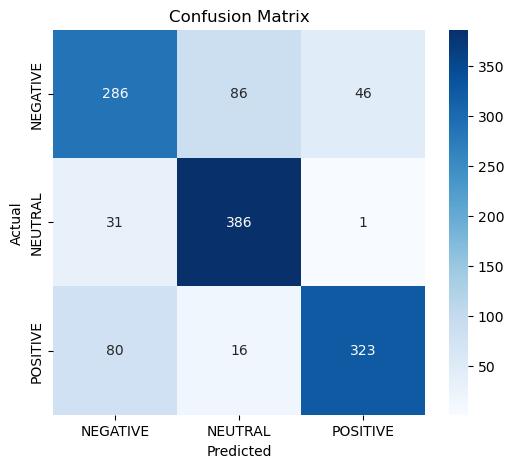

In [49]:
# confusion matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'], yticklabels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

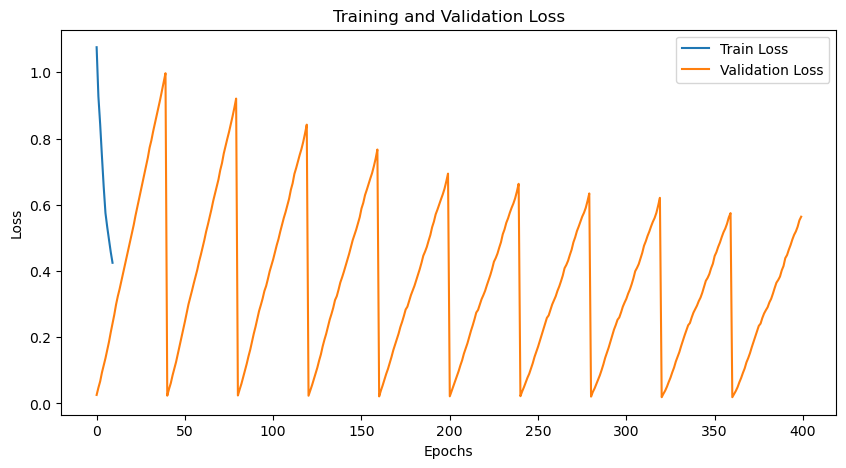

In [50]:
# Loss Visualization
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()